In [ ]:
import matplotlib.pyplot as plt

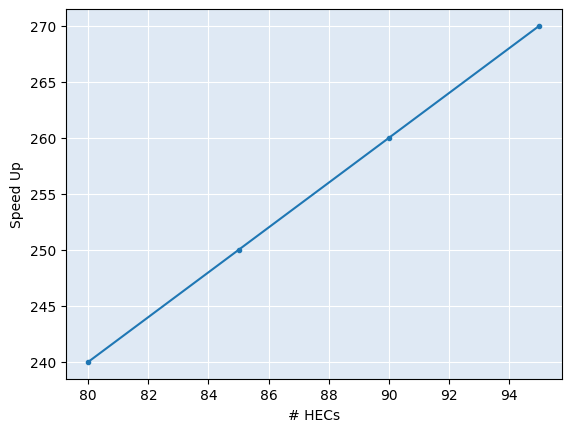

In [14]:
x = [80, 85, 90, 95]
y = [240, 250, 260, 270]

fig, ax = plt.subplots()

ax.set_xlabel("# HECs")
ax.set_ylabel("Speed Up")
ax.set_facecolor('#dfe9f4')
ax.grid(color='white', linestyle='-')

ax.plot(x, y, '.-')